## NSGA-2 tutorial 

[Reference] https://github.com/DEAP/deap/blob/master/examples/ga/nsga2.py

In [1]:
import array
import random
import json

import numpy

from math import sqrt

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools

In [2]:
# creator.create는 나의 problem에 활용학 위한 새로운 class 를 정의해줌/
# Creates a new class named name inheriting from base in the creator module.
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin) # typecode='d' => float

In [3]:
toolbox = base.Toolbox()

# Problem definition
# Functions zdt1, zdt2, zdt3, zdt6 have bounds [0, 1]
BOUND_LOW, BOUND_UP = 0.0, 1.0

# Functions zdt4 has bounds x1 = [0, 1], xn = [-5, 5], with n = 2, ..., 10
# BOUND_LOW, BOUND_UP = [0.0] + [-5.0]*9, [1.0] + [5.0]*9

# Functions zdt1, zdt2, zdt3 have 30 dimensions, zdt4 and zdt6 have 10
NDIM = 30

def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low ,up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [4]:
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", benchmarks.zdt1)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("select", tools.selNSGA2)

In [5]:
NGEN = 10
MU = 100
CXPB = 0.9

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", numpy.min, axis=0)
stats.register("max", numpy.max, axis=0)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max"

In [6]:
# test evaluate function
temp_pop = toolbox.population(n=MU)

# Evaluate the individuals with an invalid fitness
invalid_ind = [ind for ind in temp_pop if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

print(temp_pop[0].fitness.values)   # tuple로 나옴

(0.9707127995696945, 3.33852520293121)


In [13]:
pop = toolbox.population(n=MU)

# Evaluate the individuals with an invalid fitness
invalid_ind = [ind for ind in pop if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit

# This is just to assign the crowding distance to the individuals
# no actual selection is done
pop = toolbox.select(pop, len(pop))

record = stats.compile(pop)  # {'min': array([0.01830773, 2.3857476 ]), 'max': array([0.99300382, 5.40637677])}
logbook.record(gen=0, evals=len(invalid_ind), **record)
print(logbook.stream)

# Begin the generational process
for gen in range(1, NGEN):
    print(gen)
    
    # Vary the population
    # Tournament selection based on dominance (D) between two individuals,
    # if the two individuals do not interdominate the selection is made based on crowding distance (CD).    
    offspring = tools.selTournamentDCD(pop, len(pop))
    sffspring = [toolbox.clone(ind) for ind in offspring]
    
    # crossover & mutation
    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        if random.random() <= CXPB:
            toolbox.mate(ind1, ind2)
            
        toolbox.mutate(ind1)
        toolbox.mutate(ind2)
        del ind1.fitness.values, ind2.fitness.values
        
    # Evaluate the individuals with an invaid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
        
    # Select the next generation population
    pop = toolbox.select(pop + offspring, MU)
    record = stats.compile(pop)
    logbook.record(gen=gen, evals=len(invalid_ind), **record)
    print(logbook.stream)
    
print("Final population hypervolume is %f" % hypervolume(pop, [11.0, 11.0]))

gen	evals	std	min                    	avg	max                    
0  	100  	   	[0.0179958  2.85784202]	   	[0.99742835 5.49229231]
1
1  	70   	   	[0.01265331 2.29968841]	   	[0.99742835 6.1155061 ]
2
2  	88   	   	[0.03231548 2.75753113]	   	[0.97335026 5.33379696]
3
3  	96   	   	[0.02833166 2.6557321 ]	   	[0.97425288 4.94926443]
4
4  	98   	   	[0.06621399 2.61909052]	   	[0.96217521 4.10519841]
5
5  	100  	   	[0.04431125 2.5115665 ]	   	[0.98057048 4.39050907]
6
6  	99   	   	[0.01096197 2.43469644]	   	[0.99975126 4.74298999]
7
7  	100  	   	[0.00403217 2.59386912]	   	[0.99975126 4.90165977]
8
8  	100  	   	[0.14897283 2.52347448]	   	[0.95963882 4.03501141]
9
9  	100  	   	[0.18322284 2.58789129]	   	[0.91564551 4.06423997]
Final population hypervolume is 89.910594


100


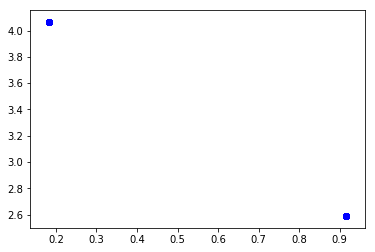

In [14]:
pop.sort(key=lambda x: x.fitness.values)

import matplotlib.pyplot as plt
%matplotlib inline
import numpy

front = numpy.array([ind.fitness.values for ind in pop])
print(len(front))
# optimal_front = numpy.array(optimal_front)
# plt.scatter(optimal_front[:,0], optimal_front[:,1], c="r")
plt.scatter(front[:,0], front[:,1], c="b")
plt.axis("tight")
plt.show()